In [137]:
from tabularbench.datasets import dataset_factory
from tabularbench.datasets import samples
import seaborn as sns
import gower
import numpy as np
import math
import pandas as pd
from tabularbench.constraints.relation_constraint import LessEqualConstraint, EqualConstraint, OrConstraint, Feature, MathOperation, Constant, ManySum, SafeDivision, LessConstraint
from IPython.display import display

In [161]:
# GLOBAL VARIABLES
CHUNK_SIZE = 1000

# SETTINGS
pd.set_option("display.max_rows", None)

In [3]:
def basic_dataset_info(dataset):
    print(f"### dataset info: {dataset.name} ###")
    meta_data = dataset.get_metadata(only_x=True)
    col_names = meta_data.columns.values.tolist()
    assert dataset.get_x_y()[0].shape[1] == meta_data.shape[0]
    assert "feature" in col_names
    assert "type" in col_names
    print(col_names)
    
    mutable_features = meta_data.query("mutable == True")
    mutable_feature_names = mutable_features["feature"].values.tolist().sort()
    mutable_feature_types = list(set(mutable_features["type"].values.tolist()))
    features_per_feature_type = {}
    for feature_type in mutable_feature_types:
        features_of_type = mutable_features.query("type == @feature_type")
        features_per_feature_type[feature_type] = features_of_type.shape[0]

    print(f"features per feature type: \n {features_per_feature_type}")
    
    print(f"total number of features: {meta_data.shape[0]}")
    print(f"number of mutable features: {mutable_features.shape[0]}")
    #print(f"mutable features: \n {mutable_feature_names}")
    print(f"mutable feature types: \n {mutable_feature_types}")
    #print(mutable_features.shape)

In [4]:
def basic_data_info(dataset):
    print(f"### data info: {dataset.name} ###")
    x, _ = dataset.get_x_y()
    print(f"x shape: {x.shape}")
    print(f"x type: {type(x)}")
    #print(f"x columns: {x.columns}")
    #print(f"x index: {x.index}")

In [81]:
def count_dict(iterable):
    dictionary = {}
    for entry in iterable:
        if entry in dictionary.keys():
            dictionary[entry] += 1
        else:
            dictionary[entry] = 1
    return dictionary

In [68]:
def cat_avg(column):
    cat_counters = count_dict(column)
    majority = max(zip(cat_counters.values(), cat_counters.keys()))[1]
    return majority
    

In [6]:
def process_chunk(x, chunk_idx, prototype, last=False):
    if last:
        x_chunk = x[chunk_idx*CHUNK_SIZE:,:]
        x_chunk_with_prototype = x_chunk.concat(prototype, ignore_index=True)
        chunk_distance_matrix = gower.gower_matrix(x_chunk_with_prototype)
        max_idx = chunk_distance_matrix.shape[0]-1
    else:
        x_chunk = x[(chunk_idx-1)*CHUNK_SIZE:chunk_idx*CHUNK_SIZE]
        x_chunk_with_prototype = pd.concat([x_chunk, prototype], ignore_index=True)
        chunk_distance_matrix = gower.gower_matrix(x_chunk_with_prototype)
        max_idx = chunk_distance_matrix.shape[0]-1
    chunk_distance_matrix = chunk_distance_matrix[max_idx,:max_idx].flatten()
    return chunk_distance_matrix

In [7]:
def gower_distance_to_prototype(dataset):
    metadata = dataset.get_metadata(only_x=True)
    x, _ = dataset.get_x_y()
    prototype = {}
    for feature in x.columns:
        feature_type = metadata.query("feature == @feature")["type"].to_list()[0]
        if feature_type == "cat":
            avg = cat_avg(x[feature])
        else:
            avg = x[feature].mean()
        prototype[feature] = avg

    prototype = pd.DataFrame.from_dict([prototype])
    #display(prototype)
    #process the distances to the prototype chunk wise, because doing it in a single gower dist matrix is too large for storage
    for chunk_idx in range(1,int(x.shape[0]/CHUNK_SIZE)+2):
        if chunk_idx == 1:
            distances_to_prototype = process_chunk(x, chunk_idx, prototype, chunk_idx == int(x.shape[0]/CHUNK_SIZE)+1)
        else:
            distances_to_prototype = np.concatenate((distances_to_prototype, process_chunk(x, chunk_idx, prototype, chunk_idx == int(x.shape[0]/100)+1)))
        
    assert distances_to_prototype.shape == (x.shape[0],)
    return distances_to_prototype
    

In [48]:
def parse_constraint(constraint):
    split_dot_list = str(constraint).split(".")
    return split_dot_list[-1][:-2]

In [117]:
def parse_constraint_list(constraints):
    constraint_type_list = list(map(type, constraints))
    return list(map(parse_constraint, constraint_type_list))

In [144]:
def print_operand(constraint):
    if isinstance(constraint, LessEqualConstraint): 
        return f"({print_operand(constraint.left_operand)} <= {print_operand(constraint.right_operand)})"
    elif isinstance(constraint, EqualConstraint):
        return f"({print_operand(constraint.left_operand)} == {print_operand(constraint.right_operand)})"
    elif isinstance(constraint, OrConstraint):
        string = f"({print_operand(constraint.operands[0])}"
        for operand in constraint.operands[1:]:
            string = string + f" OR {print_operand(operand)}"
        string = string + ")"
        return string
    elif isinstance(constraint, Feature):
        if isinstance(constraint.feature_id, str):
            if not constraint.feature_id.isnumeric():
                return f"{constraint.feature_id}"
        return f"Feature_{constraint.feature_id}"
    elif isinstance(constraint, MathOperation):
        return f"({print_operand(constraint.left_operand)} {constraint.operator} {print_operand(constraint.right_operand)})"
    elif isinstance(constraint, Constant):
        return f"{constraint.constant}"
    elif isinstance(constraint, ManySum):
        string = f"({print_operand(constraint.operands[0])}"
        for operand in constraint.operands[1:]:
            string = string + f" + {print_operand(operand)}"
        string = string + ")"
        return string
    elif isinstance(constraint, SafeDivision):
        return f"({print_operand(constraint.dividend)} / {print_operand(constraint.divisor)})"
    elif isinstance(constraint, LessConstraint):
        return f"({print_operand(constraint.left_operand)} < {print_operand(constraint.right_operand)})"
    else:
        print(f"Unknown constraint type {type(constraint)}")
        return "NONE"

In [164]:
def print_constraint_list(constraint_list):
    print("Constraints:")
    constraints = []
    for constraint in constraint_list:
        constraints.append(print_operand(constraint))
    indices = list(range(0,len(constraints)))
    df = pd.DataFrame(constraints,columns =['Constraint'])
    with pd.option_context('display.max_colwidth', None):
        display(df)


In [8]:
dataset_aliases= [
        "ctu_13_neris",
        "lcld_time",
        #"malware",
        "url",
        "wids",
    ]

# CTU 13 Neris 

In [41]:
dataset_ctu = dataset_factory.get_dataset("ctu_13_neris")   

## Basic Info 

In [10]:
basic_dataset_info(dataset_ctu)
basic_data_info(dataset_ctu)

### dataset info: ctu_13_neris ###
['feature', 'type', 'mutable', 'min', 'max', 'dyn_min', 'dyn_max']
features per feature type: 
 {'int': 343, 'real': 89}
total number of features: 757
number of mutable features: 432
mutable feature types: 
 ['int', 'real']
### data info: ctu_13_neris ###
x shape: (198128, 757)
x type: <class 'pandas.core.frame.DataFrame'>


## Gower Distances to prototype (mean feature values + majority class)

In [11]:
distances_to_prototype_ctu = gower_distance_to_prototype(dataset_ctu)

In [35]:
print(max(distances_to_prototype_ctu))
print(min(distances_to_prototype_ctu))

0.56137747
0.16163912


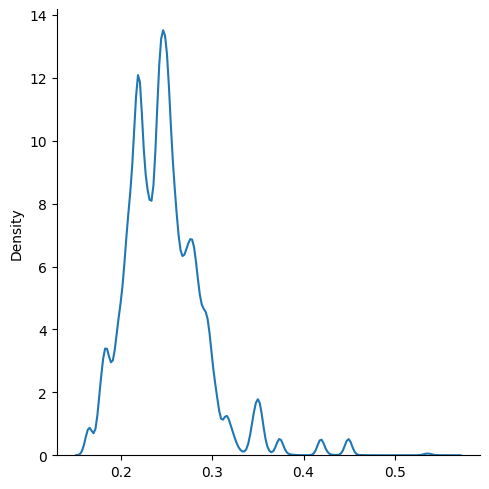

In [26]:
sns.displot(data=distances_to_prototype_ctu, kind="kde")

## constraints

In [167]:
constraints_ctu = samples.ctu_13_neris.get_relation_constraints(dataset_ctu.metadata_source)
print(f"number of constraints: {len(constraints_ctu)}")
print(f"constraint types: {count_dict(parse_constraint_list(constraints_ctu))}")

number of constraints: 360
constraint types: {'EqualConstraint': 2, 'LessEqualConstraint': 358}


In [166]:
print_constraint_list(constraints_ctu)

Constraints:


,Constraint
0,((icmp_sum_s_1 + icmp_sum_s_3 + icmp_sum_s_8 + icmp_sum_s_10 + icmp_sum_s_21 + icmp_sum_s_22 + icmp_sum_s_25 + icmp_sum_s_53 + icmp_sum_s_80 + icmp_sum_s_110 + icmp_sum_s_123 + icmp_sum_s_135 + icmp_sum_s_138 + icmp_sum_s_161 + icmp_sum_s_443 + icmp_sum_s_445 + icmp_sum_s_993 + icmp_sum_s_OTHER + (udp_sum_s_1 + udp_sum_s_3 + udp_sum_s_8 + udp_sum_s_10 + udp_sum_s_21 + udp_sum_s_22 + udp_sum_s_25 + udp_sum_s_53 + udp_sum_s_80 + udp_sum_s_110 + udp_sum_s_123 + udp_sum_s_135 + udp_sum_s_138 + udp_sum_s_161 + udp_sum_s_443 + udp_sum_s_445 + udp_sum_s_993 + udp_sum_s_OTHER) + (tcp_sum_s_1 + tcp_sum_s_3 + tcp_sum_s_8 + tcp_sum_s_10 + tcp_sum_s_21 + tcp_sum_s_22 + tcp_sum_s_25 + tcp_sum_s_53 + tcp_sum_s_80 + tcp_sum_s_110 + tcp_sum_s_123 + tcp_sum_s_135 + tcp_sum_s_138 + tcp_sum_s_161 + tcp_sum_s_443 + tcp_sum_s_445 + tcp_sum_s_993 + tcp_sum_s_OTHER)) == (bytes_in_sum_s_1 + bytes_in_sum_s_3 + bytes_in_sum_s_8 + bytes_in_sum_s_10 + bytes_in_sum_s_21 + bytes_in_sum_s_22 + bytes_in_sum_s_25 + bytes_in_sum_s_53 + bytes_in_sum_s_80 + bytes_in_sum_s_110 + bytes_in_sum_s_123 + bytes_in_sum_s_135 + bytes_in_sum_s_138 + bytes_in_sum_s_161 + bytes_in_sum_s_443 + bytes_in_sum_s_445 + bytes_in_sum_s_993 + bytes_in_sum_s_OTHER + (bytes_out_sum_s_1 + bytes_out_sum_s_3 + bytes_out_sum_s_8 + bytes_out_sum_s_10 + bytes_out_sum_s_21 + bytes_out_sum_s_22 + bytes_out_sum_s_25 + bytes_out_sum_s_53 + bytes_out_sum_s_80 + bytes_out_sum_s_110 + bytes_out_sum_s_123 + bytes_out_sum_s_135 + bytes_out_sum_s_138 + bytes_out_sum_s_161 + bytes_out_sum_s_443 + bytes_out_sum_s_445 + bytes_out_sum_s_993 + bytes_out_sum_s_OTHER)))
1,((icmp_sum_d_1 + icmp_sum_d_3 + icmp_sum_d_8 + icmp_sum_d_10 + icmp_sum_d_21 + icmp_sum_d_22 + icmp_sum_d_25 + icmp_sum_d_53 + icmp_sum_d_80 + icmp_sum_d_110 + icmp_sum_d_123 + icmp_sum_d_135 + icmp_sum_d_138 + icmp_sum_d_161 + icmp_sum_d_443 + icmp_sum_d_445 + icmp_sum_d_993 + icmp_sum_d_OTHER + (udp_sum_d_1 + udp_sum_d_3 + udp_sum_d_8 + udp_sum_d_10 + udp_sum_d_21 + udp_sum_d_22 + udp_sum_d_25 + udp_sum_d_53 + udp_sum_d_80 + udp_sum_d_110 + udp_sum_d_123 + udp_sum_d_135 + udp_sum_d_138 + udp_sum_d_161 + udp_sum_d_443 + udp_sum_d_445 + udp_sum_d_993 + udp_sum_d_OTHER) + (tcp_sum_d_1 + tcp_sum_d_3 + tcp_sum_d_8 + tcp_sum_d_10 + tcp_sum_d_21 + tcp_sum_d_22 + tcp_sum_d_25 + tcp_sum_d_53 + tcp_sum_d_80 + tcp_sum_d_110 + tcp_sum_d_123 + tcp_sum_d_135 + tcp_sum_d_138 + tcp_sum_d_161 + tcp_sum_d_443 + tcp_sum_d_445 + tcp_sum_d_993 + tcp_sum_d_OTHER)) == (bytes_in_sum_d_1 + bytes_in_sum_d_3 + bytes_in_sum_d_8 + bytes_in_sum_d_10 + bytes_in_sum_d_21 + bytes_in_sum_d_22 + bytes_in_sum_d_25 + bytes_in_sum_d_53 + bytes_in_sum_d_80 + bytes_in_sum_d_110 + bytes_in_sum_d_123 + bytes_in_sum_d_135 + bytes_in_sum_d_138 + bytes_in_sum_d_161 + bytes_in_sum_d_443 + bytes_in_sum_d_445 + bytes_in_sum_d_993 + bytes_in_sum_d_OTHER + (bytes_out_sum_d_1 + bytes_out_sum_d_3 + bytes_out_sum_d_8 + bytes_out_sum_d_10 + bytes_out_sum_d_21 + bytes_out_sum_d_22 + bytes_out_sum_d_25 + bytes_out_sum_d_53 + bytes_out_sum_d_80 + bytes_out_sum_d_110 + bytes_out_sum_d_123 + bytes_out_sum_d_135 + bytes_out_sum_d_138 + bytes_out_sum_d_161 + bytes_out_sum_d_443 + bytes_out_sum_d_445 + bytes_out_sum_d_993 + bytes_out_sum_d_OTHER)))
2,((bytes_out_sum_s_1 / pkts_out_sum_s_1) <= 1500)
3,((bytes_out_sum_s_3 / pkts_out_sum_s_3) <= 1500)
4,((bytes_out_sum_s_8 / pkts_out_sum_s_8) <= 1500)
5,((bytes_out_sum_s_10 / pkts_out_sum_s_10) <= 1500)
6,((bytes_out_sum_s_21 / pkts_out_sum_s_21) <= 1500)
7,((bytes_out_sum_s_22 / pkts_out_sum_s_22) <= 1500)
8,((bytes_out_sum_s_25 / pkts_out_sum_s_25) <= 1500)
9,((bytes_out_sum_s_53 / pkts_out_sum_s_53) <= 1500)


# lcld_time

In [75]:
dataset_lcld = dataset_factory.get_dataset("lcld_time")  

## Basic Info 

In [14]:
basic_dataset_info(dataset_lcld)
basic_data_info(dataset_lcld)

### dataset info: lcld_time ###
['feature', 'min', 'max', 'mutable', 'type']
features per feature type: 
 {'int': 4, 'real': 8, 'cat': 2}
total number of features: 28
number of mutable features: 14
mutable feature types: 
 ['int', 'real', 'cat']
### data info: lcld_time ###
x shape: (1220092, 28)
x type: <class 'pandas.core.frame.DataFrame'>


## Gower Distances to prototype (mean feature values + majority class)

In [15]:
distances_to_prototype_lcld = gower_distance_to_prototype(dataset_lcld)

In [36]:
print(max(distances_to_prototype_lcld))
print(min(distances_to_prototype_lcld))

0.46087912
0.06334252


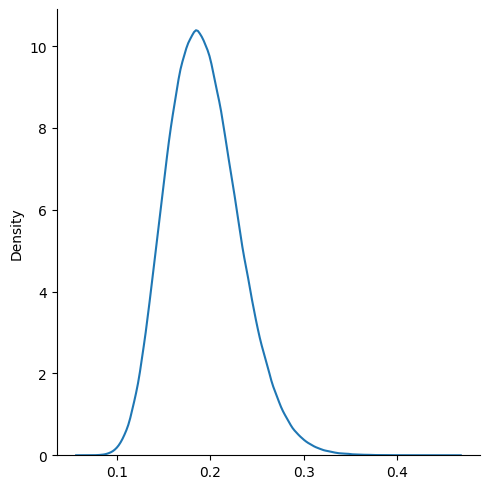

In [29]:
sns.displot(data=distances_to_prototype_lcld, kind="kde")

## constraints

In [170]:
constraints_lcld = samples.lcld.get_relation_constraints()
print(f"number of constraints: {len(constraints_lcld)}")
print(f"constraint types: {count_dict(parse_constraint_list(constraints_lcld))}")

number of constraints: 9
constraint types: {'EqualConstraint': 6, 'LessEqualConstraint': 2, 'OrConstraint': 1}


In [168]:
print_constraint_list(constraints_lcld)

Constraints:


,Constraint
0,(installment == (loan_amnt * (((int_rate / 1200) * ((1 + (int_rate / 1200)) ** term)) / (((1 + (int_rate / 1200)) ** term) - 1))))
1,(open_acc <= total_acc)
2,(pub_rec_bankruptcies <= pub_rec)
3,((term == 36) OR (term == 60))
4,(ratio_loan_amnt_annual_inc == (loan_amnt / annual_inc))
5,(ratio_open_acc_total_acc == (open_acc / total_acc))
6,(ratio_pub_rec_month_since_earliest_cr_line == (pub_rec / month_since_earliest_cr_line))
7,(ratio_pub_rec_bankruptcies_month_since_earliest_cr_line == (pub_rec_bankruptcies / month_since_earliest_cr_line))
8,(ratio_pub_rec_bankruptcies_pub_rec == (pub_rec_bankruptcies / pub_rec))


# url

In [17]:
dataset_url = dataset_factory.get_dataset("url")  

## Basic Info 

In [18]:
basic_dataset_info(dataset_url)
basic_data_info(dataset_url)

### dataset info: url ###
['feature', 'type', 'mutable', 'min', 'max']
features per feature type: 
 {'int': 58, 'real': 5}
total number of features: 63
number of mutable features: 63
mutable feature types: 
 ['int', 'real']
### data info: url ###
x shape: (11430, 63)
x type: <class 'pandas.core.frame.DataFrame'>


## Gower Distances to prototype (mean feature values + majority class)

In [19]:
distances_to_prototype_url = gower_distance_to_prototype(dataset_url)

In [34]:
print(max(distances_to_prototype_url))
print(min(distances_to_prototype_url))

0.45190325
0.06894471


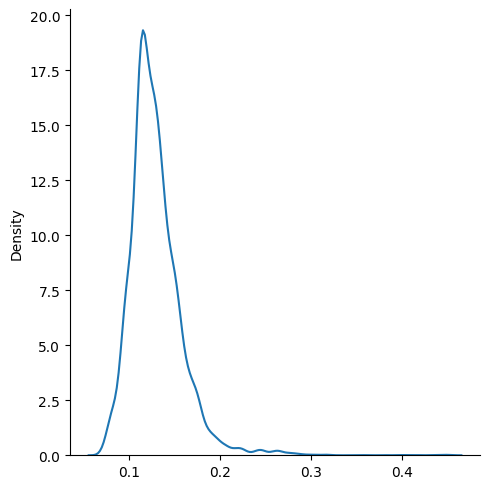

In [28]:
sns.displot(data=distances_to_prototype_url, kind="kde")

## constraints

In [172]:
constraints_url = samples.url.get_relation_constraints()
print(f"number of constraints: {len(constraints_url)}")
print(f"constraint types: {count_dict(parse_constraint_list(constraints_url))}")

number of constraints: 14
constraint types: {'LessEqualConstraint': 8, 'OrConstraint': 6}


In [171]:
print_constraint_list(constraints_url)

Constraints:


,Constraint
0,(Feature_1 <= Feature_0)
1,((Feature_3 + Feature_4 + Feature_5 + Feature_6 + Feature_7 + Feature_8 + Feature_9 + Feature_10 + Feature_11 + Feature_12 + Feature_13 + Feature_14 + Feature_15 + Feature_16 + Feature_17 + (3 * Feature_19)) <= Feature_0)
2,((0 <= Feature_21) OR (0 < Feature_3))
3,((0 <= Feature_23) OR (0 < Feature_13))
4,(((3 * Feature_20) + (4 * Feature_21) + (2 * Feature_23)) <= Feature_0)
5,((0 <= Feature_19) OR (0 < Feature_25))
6,((0 <= Feature_2) OR (0 < Feature_25))
7,((0 <= Feature_28) OR (0 < Feature_25))
8,((0 <= Feature_31) OR (0 < Feature_26))
9,(Feature_38 <= Feature_37)


# wids

In [62]:
dataset_wids = dataset_factory.get_dataset("wids")

## Basic Info 

In [22]:
basic_dataset_info(dataset_wids)
basic_data_info(dataset_wids)

### dataset info: wids ###
['feature', 'min', 'max', 'mutable', 'type']
features per feature type: 
 {'int': 60, 'real': 39, 'cat': 9}
total number of features: 108
number of mutable features: 108
mutable feature types: 
 ['int', 'real', 'cat']
### data info: wids ###
x shape: (34776, 108)
x type: <class 'pandas.core.frame.DataFrame'>


## Gower Distances to prototype (mean feature values + majority class)

In [23]:
distances_to_prototype_wids = gower_distance_to_prototype(dataset_wids)

In [37]:
print(max(distances_to_prototype_wids))
print(min(distances_to_prototype_wids))

0.3054491
0.076480545


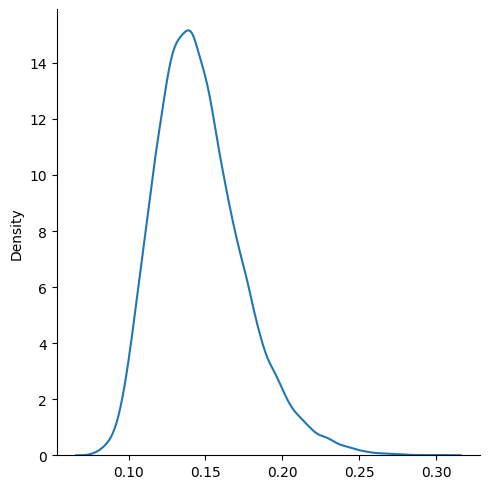

In [27]:
sns.displot(data=distances_to_prototype_wids, kind="kde")

In [173]:
constraints_wids = samples.wids.get_relation_constraints(dataset_wids.metadata_source)
print(f"number of constraints: {len(constraints_wids)}")
print(f"constraint types: {count_dict(parse_constraint_list(constraints_wids))}")

number of constraints: 31
constraint types: {'LessEqualConstraint': 31}


In [174]:
print_constraint_list(constraints_wids)

Constraints:


,Constraint
0,(Feature_34 <= Feature_33)
1,(Feature_36 <= Feature_35)
2,(Feature_38 <= Feature_37)
3,(Feature_40 <= Feature_39)
4,(Feature_42 <= Feature_41)
5,(Feature_44 <= Feature_43)
6,(Feature_46 <= Feature_45)
7,(Feature_48 <= Feature_47)
8,(Feature_50 <= Feature_49)
9,(Feature_52 <= Feature_51)
